REFERENCEs:
Wilks "Statistical Methods in the Atmospheric Sciences" 4th edition 2019
pg 115-118

lmoments library python  https://lmoments3.readthedocs.io/_/downloads/en/stable/pdf/

https://stackoverflow.com/questions/52455797/python-fitting-a-gev-distribution-from-these-values

In [73]:
import joblib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import genextreme as gev
import lmoments3 as lm3

In [74]:
rainfall_data = joblib.load('rainfall_data_2011_2020_835x_520y.pkl') #10min rain
rain_resampled = rainfall_data.resample(time='1D').sum()

print(f"Maximum rainfall in your resample data is: {rain_resampled.values.max()} mm")

# Get the annual maxima

annual_max = rain_resampled.resample(time='1Y').max()
annual_max = annual_max.dropna('time')
POT_threshold = min(annual_max.values) # Peak Over Threshold

print(f"Threshold for POT is: {POT_threshold} mm")

Maximum rainfall in your resample data is: 224.39175415039062 mm
Threshold for POT is: 105.30184173583984 mm


In [75]:
rain_POT = rain_resampled.where(rain_resampled >= POT_threshold, drop=True)  # Peak Over Threshold
print(f"Number of POT events: {rain_POT.count()}")

Number of POT events: <xarray.DataArray 'RAIN' ()>
array(32)


### D. Fit distribution to GEV using Maximum Likelihood Estimation

In [76]:
shape, loc, scale = gev.fit(rain_POT)
l = loc + scale / shape
print('Fitting to GEV distribution using MLE')
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

Fitting to GEV distribution using MLE
Shape: -0.5475146283634681, Location: 116.64296648227787, Scale: 12.377086181035382


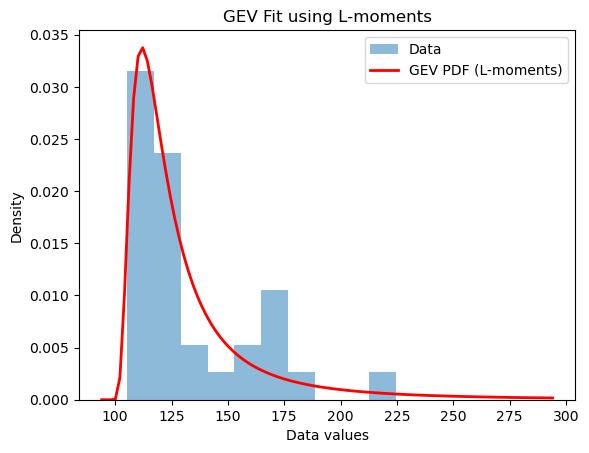

In [ ]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = gev.pdf(xx, shape, loc, scale)
plt.hist(rain_POT, bins=10, density=True, alpha=0.5, label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (MLE)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using MLE")
plt.legend()
plt.show()


### E. Fit distribution to GEV using L-Moments (adequate for small samples)

In [78]:
lmom = lm3.lmom_ratios(rain_POT, nmom=5)
print(f"Sample L-moments: {lmom}")
gev_params = lm3.distr.gev.lmom_fit(rain_POT)
print(f"Fitted GEV parameters using L-moments:")
print(f"Shape: {gev_params['c']}, Location: {gev_params['loc']}, Scale: {gev_params['scale']}")
shape, loc, scale = gev_params['c'], gev_params['loc'], gev_params['scale']
l = loc + scale / shape

Sample L-moments: [132.55848789215088, 14.642591507204116, 0.35941789046183337, 0.14909107998588716, 0.03328303812186331]
Fitted GEV parameters using L-moments:
Shape: -0.27509808235099525, Location: 118.16256634602631, Scale: 15.214399010927496


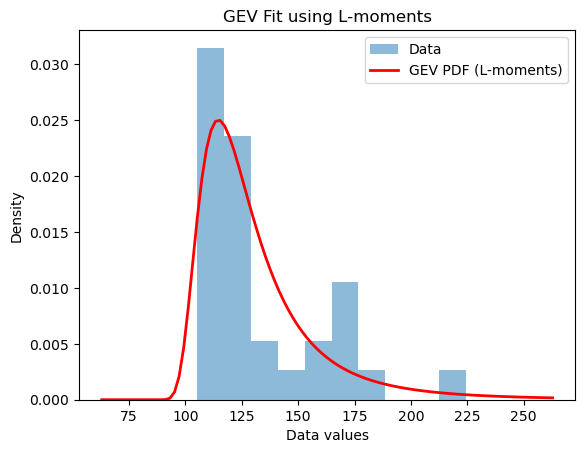

In [ ]:
#Plotting
xx = np.linspace(l+0.00001, l+0.00001+200, num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gev = lm3.distr.gev.pdf(xx, **gev_params)
plt.hist(rain_POT, bins=10, density=True, alpha=0.5,  label="Model")
plt.plot(xx, pdf_gev, 'r-', lw=2, label="GEV PDF (L-moments)")
plt.xlabel("Data values")
plt.ylabel("Density")
plt.title("GEV Fit using L-moments")
plt.legend()
plt.show()

### F. Fit GPD (Generalized Pareto Distribution) to exceedances (MLE)

GPD Fit Parameters: Shape (ξ) = 0.0302, Scale (σ) = 26.4375, Location (μ) = 0


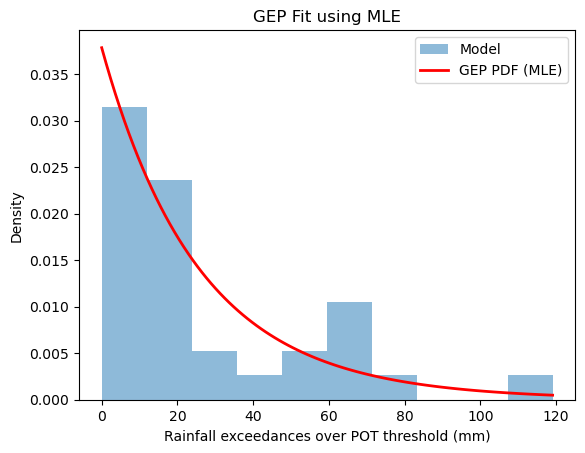

In [80]:
exceedances = rain_POT - POT_threshold
shape, loc, scale = stats.genpareto.fit(exceedances.values, floc=0)

print(f"GPD Fit Parameters: Shape (ξ) = {shape:.4f}, Scale (σ) = {scale:.4f}, Location (μ) = {loc}")

#Plotting
xx = np.linspace(0, max(exceedances), num=100)
#xx = np.linspace(min(rain_over_threshold), max(rain_over_threshold), 100)
pdf_gep = stats.genpareto.pdf(xx, shape, loc=loc, scale=scale)
plt.hist(exceedances, bins=10, density=True, alpha=0.5, label="Model")
plt.plot(xx, pdf_gep, 'r-', lw=2, label="GEP PDF (MLE)")
plt.xlabel("Rainfall exceedances over POT threshold (mm)")
plt.ylabel("Density")
plt.title("GEP Fit using MLE")
plt.legend()
plt.show()
